# Notes

- This method only works up to 3 states per chain, for which it correctly recovers everything. For chains with $\geq4$ states, it splits the chain into smaller chains with 2 or 3 states. 

In [1]:
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
import multiprocessing
NumThread=(multiprocessing.cpu_count()-1)*2 # sets number of workers based on cpus on current machine
print('Parallel processing with '+str(NumThread)+' cores')
# fix random seed
npr.seed(2)
import time 
import os


# from util_factorial_hmm import gibbs

%load_ext autoreload
%autoreload 2
from new_utils_modelsel import *
from new_model_fitting_utility_functions import *
save_fig_folder='fig_modelsel/'
# if save_fig_folder does not exist, create it
if not os.path.exists(save_fig_folder):
    os.makedirs(save_fig_folder)
    
if not os.path.exists('data/'):
    os.makedirs('data/')


Parallel processing with 18 cores


## Generate fHMM with 2 chains and different timescales

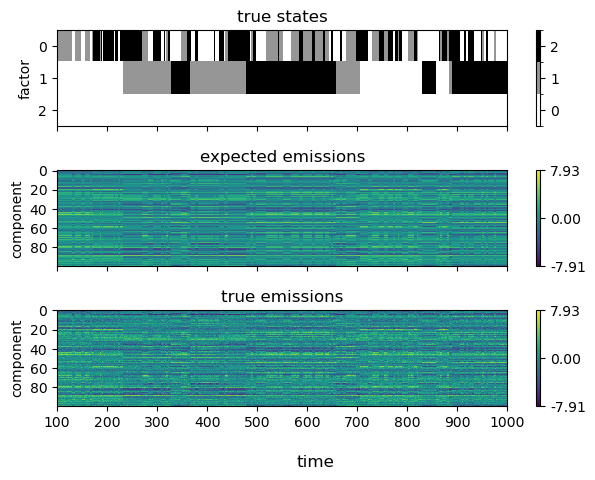

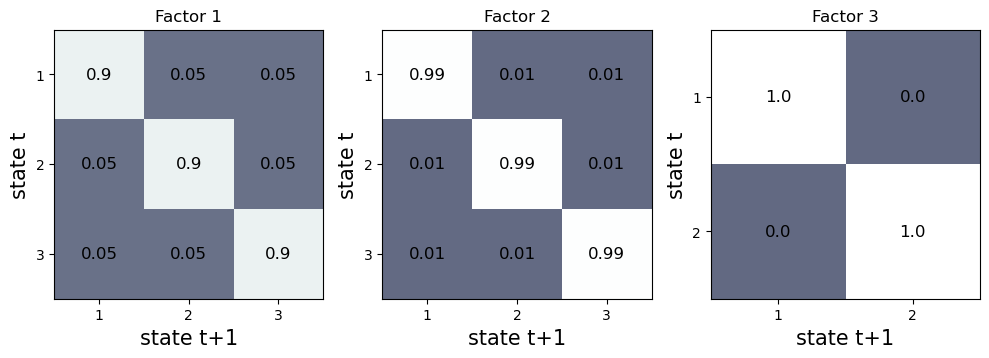

In [2]:
# num_factors = 5
# num_states = [3, 3, 3, 3, 2]  # Different numbers of states per factor
num_states = [3,3,2]  # Different numbers of states per factor
num_factors = len(num_states)
emission_dim = 100
num_timesteps = 10000

emission_option='mixedsel' # the emissions from different factors are mixed
# emission_option='puresel'# each neuron only depends on one factor

trans_diag = [0 for i in range(num_factors)]
for i in range(num_factors):
        if i < np.min([4,num_factors]):
            epsi = 10 ** (-i - 1)
        trans_diag[i] = (1 - epsi)

data = generate_fHMM_data(num_factors, num_states, emission_dim, num_timesteps, trans_diag, rand_seed = None, selectivity = "mixedsel", mean_scalar = 1)
x=np.save('data/data1.npy',data)


# unpack data into variables whose name is the key with a loop
for key in data.keys():
    exec(key+'=data["'+key+'"]')
for key in params.keys():
    exec(key+'=params["'+key+'"]')

plot_fHMM_model(data, lower=100, upper=1000)
# plt.savefig(save_fig_folder+'fHMM_generatedData.svg', pad_inches=0, backend='svg')
plt.savefig(save_fig_folder+'fHMM_generatedData.pdf', pad_inches=0, backend='pdf')
plt.savefig(save_fig_folder+'fHMM_generatedData.png')

# PLOT

plt.figure(figsize=(10, 15))
for i in range(num_factors):
    ax = plt.subplot(1, num_factors, i+1)
    plot_trans_matrix(transition_matrices[i])
    # write values on the diagonal as exponential in base 10
    ax.set_title(f"Factor {i+1}")
plt.tight_layout()
plt.savefig(save_fig_folder+'tpm.pdf')



# Model selection

1. Perform cross-validated ICA to select for the number of ICA sources $L$. Given the data $Y_{i,t}$ for neuron $i$ and time $t$, we perform ICA on the whitened data to obtain the $L$ sources $s_{l,t}$ and the mixing matrix $H_{i,l}$ with
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} \ .
$$

2. On each of the sources $l=1,\ldots,L$, run model selection with a gaussian mixture model (GMM) to find the optimal number of mixtures $n_l$ that best describe that source. 

3. For each source $l$, fit an HMM with $m=1,\ldots,M_l$ states to each source $S_{l,t}$ and store posteriors and emissions
          $$
          S_{l,t}=\sum_{m=1}^{M_l}e_m^{(l)}p^{(l)}(m,t)
          $$
          where $\{e_m^{(l)},p^{(l)}(m,t)\}$ are the emissions and posterior probabilities for HMM state $m$ for source $l$.

4. Concatenate all posteriors from all HMM of all sources for a total of $S=\sum_{l=1}^L M_l$, and estimate their $S x S$ correlation matrix. Find groups of highly correlated posteriors (abs(corr)$>0.95$) representing identical copies of the same HMM state that was detected in more than one ICA source. For each group of highly correlated posteriors, keep only one copy and drop the rest, thus decreasing the number of total posteriors from S to $\hat S$.

5. Consider the $\hat S \times \hat S$ correlation matrix between the surviving posteriors, and now perform hierarchical clustering on it, to find $c=1,\ldots,C$ chains of most anticorrelated posteriors, each group with $N_c$ states. E.g., groups of posteriors with anticorrelation of $-1/(K-1)$ correspond to a Markov chain with K states. Normalize the posteriors within each chain such that $\sum_{n=1}^{N_c}p^{(c)}(n,t)=1$ for all $t$ and all chains $c$, so that the original data reads
$$
Y_{i,t}=\sum_{l=1}^{L}H_{i,l}S_{l,t}+Y_{mean} =\sum_{c=1}^C H_{i,c} \sum_{n=1}^{N_c}e_n^{(c)}p^{(c)}(n,t)
$$

6. Initialization of fHMM parameters. The procedure above defines an fHMM with **emissions** $E_i(n,c)$ for state $n$ in chain $c$ given by
$$
E_i(n,c)=H_{i,c}e_n^{(c)}+Y_{mean,i},
$$
**transition probabilities** $A_{nm}^{(c)}$ and initial distribution $\pi_n^{(c)}$ for the chain c obtained from the posteriors as:
$$
A_{nm} \ ,\qquad \pi_n^{(c)}=p^{(c)}(n,t=0) \ .
$$




# Step 1: select number of ICA sources

/Users/mazzu/opt/anaconda3/envs/fhmm_luca/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/fhmm_luca/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/fhmm_luca/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/fhmm_luca/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/mazzu/opt/anaconda3/envs/fhmm_luca/li

Optimal number of components based on the plateau method: 5
best n_components by PCA CV = 12, FA CV = 5, ICA CV = 5


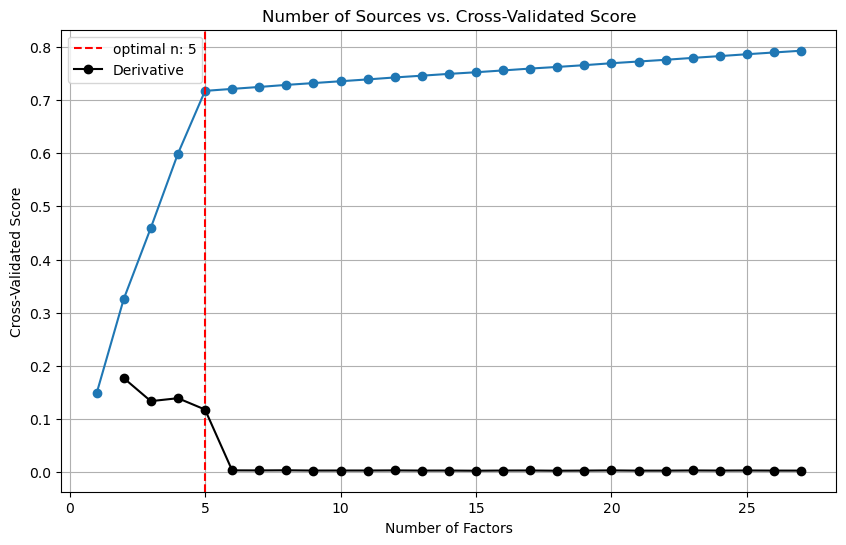

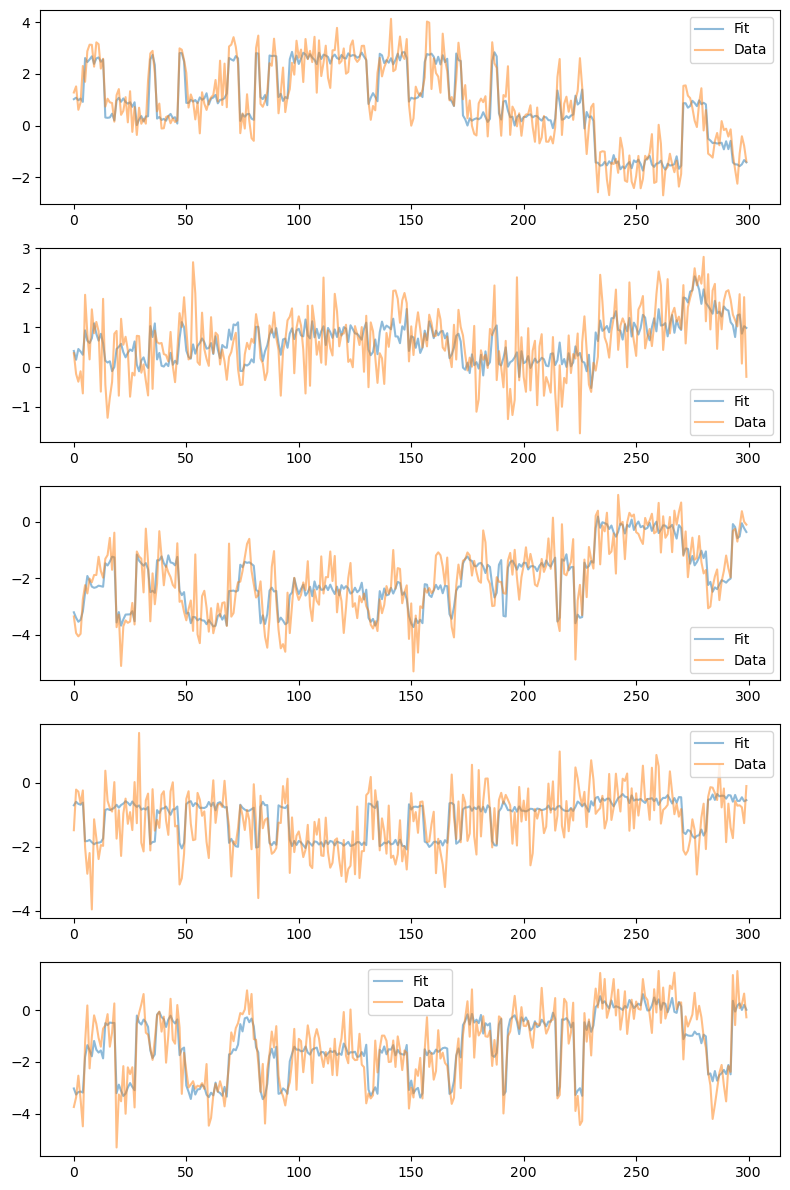

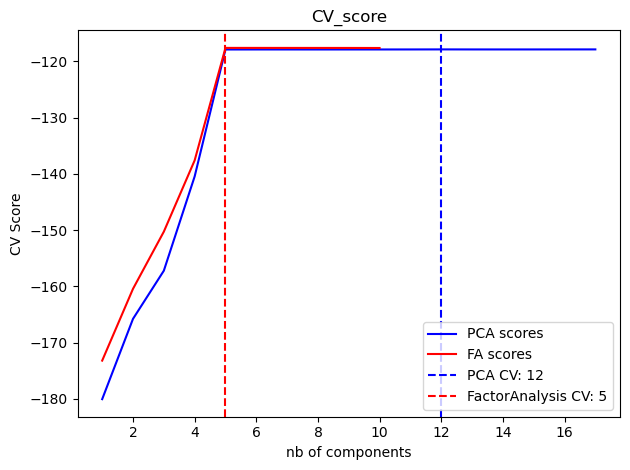

/Users/mazzu/opt/anaconda3/envs/fhmm_luca/lib/python3.9/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
LP: 4144.5:  60%|██████    | 301/500 [00:02<00:01, 109.66it/s]

3
[-1.45797141683771, -0.520126473550372, 0.6003949537825171, 0.6004182274439488, 0.5967924165613419, 0.5991269404572547, 0.5960366552221317, 0.5981374690437999, 0.5984018636912438]


LP: 4144.5:  65%|██████▍   | 323/500 [00:03<00:01, 108.45it/s]

2
[-3.0800290895488245, 0.7768130966961463, 0.7783764160317898, 0.7783248575990744, 0.7780609572164215, 0.7819496098938469, 0.7773254338457182, 0.7906527469121677, 0.7802171173416897]


LP: 2345.9:  35%|███▌      | 177/500 [00:01<00:02, 108.61it/s]

2
[-1.4002863242225352, 0.49877998636267445, 0.5791000132812589, 0.5794724154089254, 0.5031916199285221, 0.5780804511013925, 0.5892236533907355, 0.5915170872047864, 0.5801591371869512]


LP: 2093.3:  64%|██████▍   | 320/500 [00:03<00:01, 97.98it/s]

3
[-1.4278340716340072, -0.26216489575926083, 0.22533253252338825, 0.22939048629658698, 0.2279041506025604, 0.2225774531016921, 0.22464085972981293, 0.22090946173481785, 0.2121422247297637]


Converged to LP: 1978.4:  64%|██████▍   | 321/500 [00:03<00:01, 106.44it/s]


3
[-1.416457829762096, -0.33210431301624993, 0.27587307959027246, 0.2753402910109846, 0.2759767888070462, 0.27514434679247196, 0.27424527165412893, 0.27235263227465567, 0.2723335803919064]


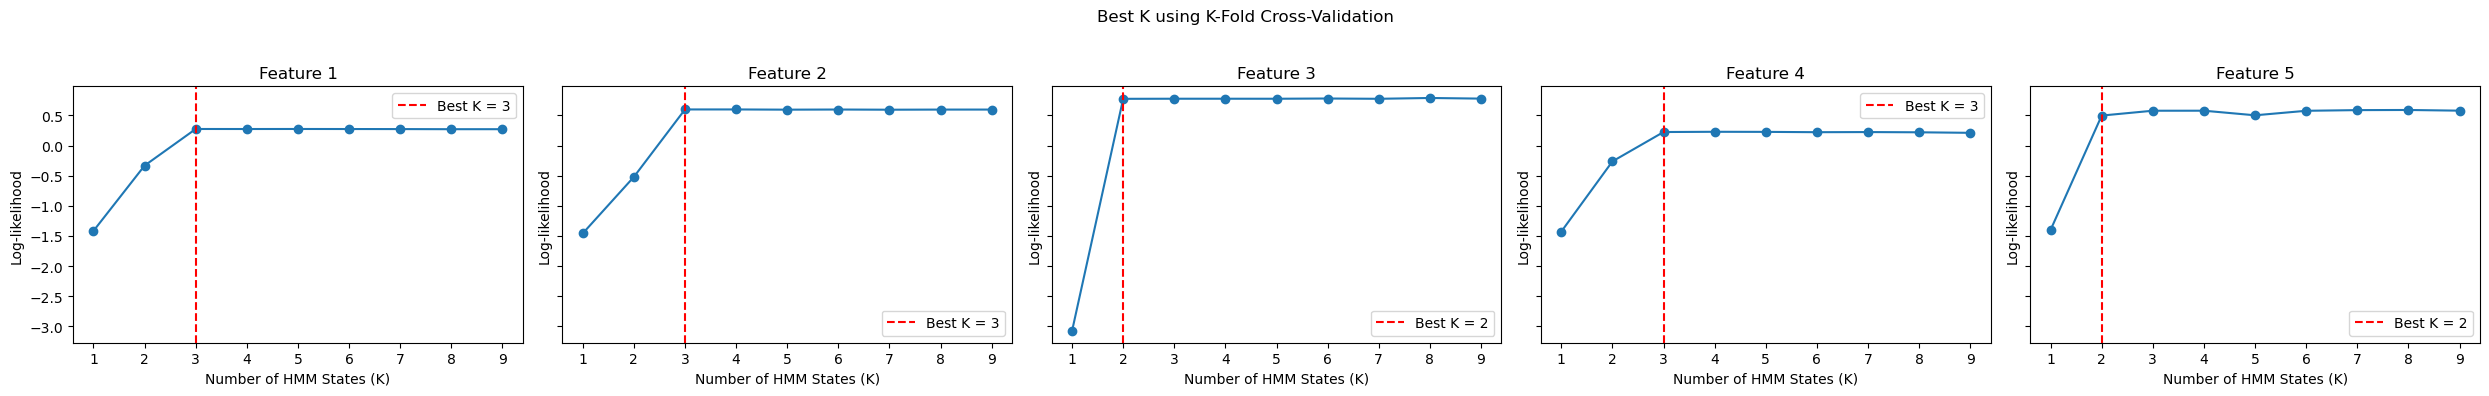

best number of states by each method for HMM case: 
 original method   : [3, 3, 2, 3, 2]


In [3]:
MAX_runs=40
emissions_data = data['fHMM_data']['emissions']
n_components = np.arange(1, np.min([emissions_data.shape[1],MAX_runs]), 1)  # options for n_components
file_save=save_fig_folder+'ModelSel_ICA'
ica,optimal_n_components,n_factors_range,average_variances=model_sel_ICA(emissions_data,MAX_runs=MAX_runs,file_save=file_save,method='elbow')
factors=ica.transform(emissions_data)
# plateau_idx = find_plateau_point(average_variances, start_monitor=10, window=5, patience=5)
# print(plateau_idx)
# num_factors_FA=factors.shape[1]

"""
COMPARE TO PCA,FA modelsel with max likelihood
"""
MAX_runs=30
file_save=save_fig_folder+'ModelSel_FA_PCA'
n_components = np.arange(1, np.min([emissions_data.shape[1],MAX_runs]), 1)  # options for n_components
pca_scores, fa_scores, tested_n_pca, tested_n_fa, best_n_pca, best_n_fa = compute_scores_pca_fa(emissions_data,n_components,method='max',patience=5)
# n_components_pca = n_components[np.argmax(pca_scores)]
# n_components_fa = n_components[np.argmax(fa_scores)]
# n_components_pca = find_plateau_point(pca_scores)
# n_components_fa = find_plateau_point(fa_scores)
n_components_ica = optimal_n_components
print(f"best n_components by PCA CV = {best_n_pca}, FA CV = {best_n_fa}, ICA CV = {n_components_ica}")
file_save1=file_save+'.pdf'
# save_cv_scores_plot(pca_scores, fa_scores, n_components_pca, n_components_fa, tested_n_pca, tested_n_fa, file_save1, title=OptionScore)
plt.figure()

plt.plot(tested_n_pca, pca_scores, "b", label="PCA scores")
plt.plot(tested_n_fa, fa_scores, "r", label="FA scores")
plt.axvline(best_n_pca, color="b", label=f"PCA CV: {best_n_pca}", linestyle="--")
plt.axvline(best_n_fa, color="r", label=f"FactorAnalysis CV: {best_n_fa}", linestyle="--")
plt.xlabel("nb of components")
plt.ylabel("CV Score")
plt.legend(loc="lower right")
plt.title('CV_score')
plt.tight_layout()
plt.savefig(file_save1, format="pdf")
plt.show()
# plt.close()

"""
TIMESCALES
"""
file_timescale=save_fig_folder+'ICA_'

timescales,labels,optimal_n_timescales=infer_timescales(factors,file_save=file_timescale)

"""
HMM on ICA components
"""

# option='GMM' # this takes 10s, it works great with simulated data, not as much with real data.
# option='HMM' # this takes 3m.
file_save=save_fig_folder+'Fit2FactorsSelection'
results_HMM, n_states_best_HMM = fit2sources_findNumStates(factors,'HMM',file_save)
# results_GMM, n_states_best_GMM = fit2sources_findNumStates(factors,'GMM',file_save)

n_states_best_dict_HMM = {'line method': n_states_best_HMM}
print(f'best number of states by each method for HMM case: \n \
original method   : {n_states_best_dict_HMM["line method"]}')

# dict = {'save_session':save_session,'ica':ica,'factors':factors,'timescales':timescales,'n_states_best_dict_HMM':n_states_best_dict_HMM,'results_HMM':results_HMM}
# file_beh=save_session+OptionData+'_ICA_HMM_modelsel1.npy'
# np.save(file_beh,dict)

# return n_states_best_dict_HMM, results_HMM

Converged to LP: 3047.2:   3%|▎         | 28/1000 [00:00<00:06, 145.79it/s]


neg_correlated_groups: []
Selected features: [0, 2, 3, 4, 6, 7, 9, 12]


/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/fHMM/FiguresForPaper/new_utils_modelsel.py:1206: RuntimeWarning: Mean of empty slice
  average = np.nanmean(matrix_copy)
/Users/mazzu/Library/CloudStorage/Dropbox/neuro/PROJECTS/fHMM/FiguresForPaper/new_utils_modelsel.py:1762: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{float(tick.get_text()) - 1:.2f}' for tick in plt.gca().get_yticklabels()])


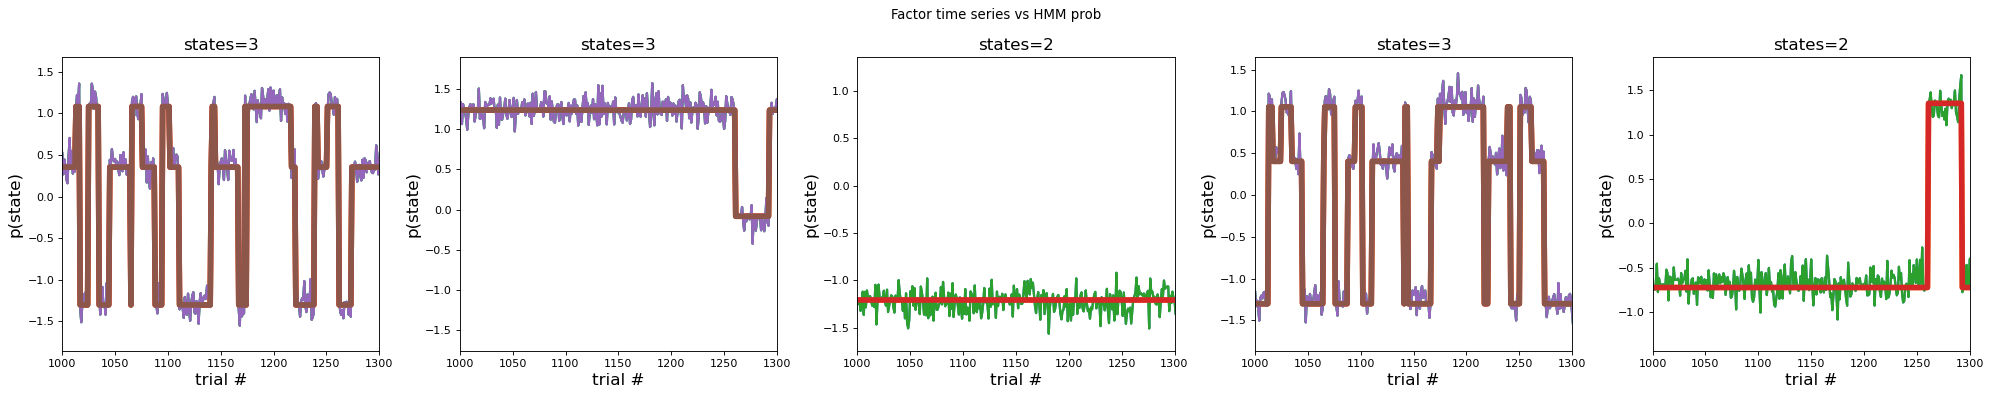

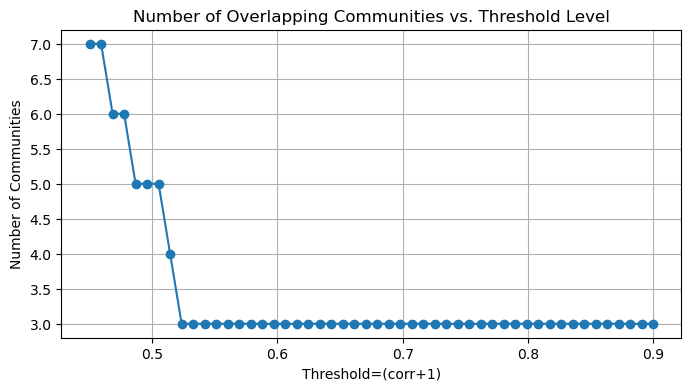

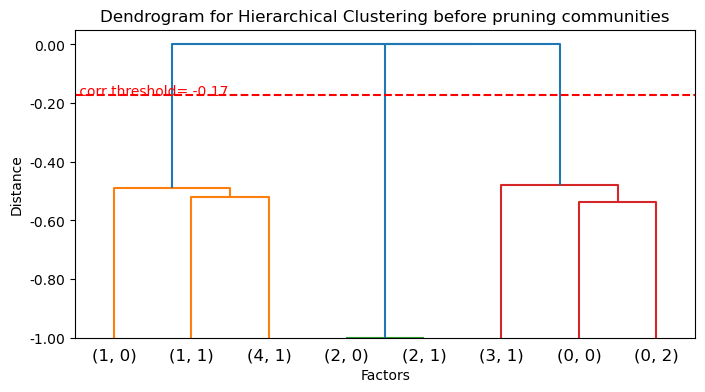

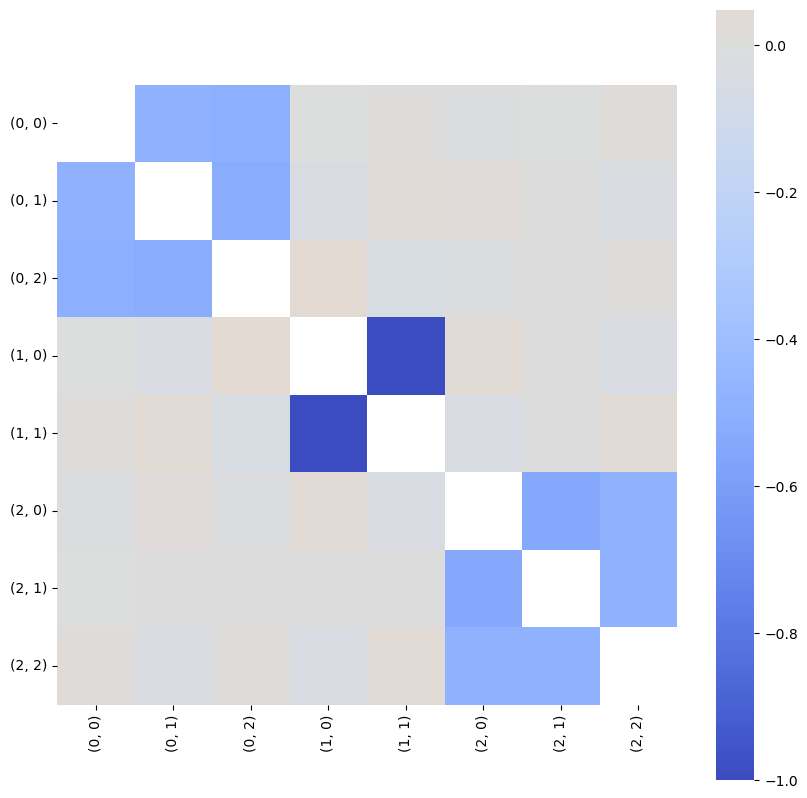

In [4]:
# factors = dict_load['factors']
# timescales = dict_load['timescales']
# n_states_best_dict_HMM = dict_load['n_states_best_dict_HMM']
# save_session = dict_load['save_session']
# ica = dict_load['ica']
# results_HMM = dict_load['results_HMM']
n_states_best_HMM = n_states_best_dict_HMM['line method']

file_save=save_fig_folder+'SampleFit'
hmm_fits_HMM = fit_hmm_after_gmm(factors, n_states_best_HMM, timescales=None,file_save=file_save)

file_duplicate=save_fig_folder+'remove_duplicate_hmms'
data_factors_to_keep_HMM, new_corr_matrix_HMM, data_factors_HMM = \
remove_duplicate_hmms(hmm_fits_HMM,threshold=0.18,threshold_low=1.1,threshold_hi=0.1,file_save=file_duplicate)

correlation_matrix_HMM = new_corr_matrix_HMM
file_dendro=save_fig_folder
# id_communities_HMM, mean_corr_communities_HMM, data_factors_to_keep_filtered_HMM=cluster_hmm(correlation_matrix_HMM, data_factors_to_keep_HMM,file_save=file_dendro)
id_communities_HMM, mean_corr_communities_HMM, data_factors_to_keep_filtered_HMM=cluster_hmm(correlation_matrix_HMM, data_factors_to_keep_HMM,file_save=file_dendro,threshold_choice=-.17)

# n_states_best_dict_HMM['used'] =  n_states_best_HMM

means_rec_HMM, posteriors_rec_HMM, transitions_rec_HMM, init_rec_HMM = reconstruct_parameters(id_communities_HMM, data_factors_to_keep_filtered_HMM, ica)

dict_save = {'n_states_best_dict_HMM':n_states_best_dict_HMM,'means_rec_HMM':means_rec_HMM,'posteriors_rec_HMM':posteriors_rec_HMM,'transitions_rec_HMM':transitions_rec_HMM,'init_rec_HMM':init_rec_HMM}
file_save=save_fig_folder+'HMM_reconstruction.npy'
np.save(file_save,dict_save)



corr_matrix = np.corrcoef(np.hstack(posteriors_rec_HMM).T)
# fig = plt.figure(figsize=(10, 10))
labels_hmm = [f'({factor_idx}, {state_idx})' for factor_idx in range(len(posteriors_rec_HMM)) for state_idx in range(len(posteriors_rec_HMM[factor_idx][0]))]
# vlim = np.abs(corr_matrix).max()
fig = plt.figure(figsize=(10, 10))
np.fill_diagonal(corr_matrix, np.nan)
sns.heatmap(corr_matrix, annot=False,
          center=0, cmap='coolwarm',
          square=True)



# Removed redundant cmap definition
# replace x and y ticklabels with  labels_hmm
plt.yticks(ticks=np.arange(len(labels_hmm))+.5, labels=labels_hmm, rotation=0)
plt.xticks(ticks=np.arange(len(labels_hmm))+.5, labels=labels_hmm, rotation=90)
file_final_corr=save_fig_folder+'posteriors_init_corr.pdf'
plt.savefig(file_final_corr)
plt.show()

# Compare with ground truth

Best match: ICA Factor 2 with True state 3 (Factor 1) with correlation 1.0
unmatched_factors [0, 1, 3, 4, 5, 6, 7]
Best match: ICA Factor 3 with True state 6 (Factor 2) with correlation 1.0
unmatched_factors [0, 1, 4, 5, 6, 7]
Best match: ICA Factor 4 with True state 7 (Factor 2) with correlation 1.0
unmatched_factors [0, 1, 5, 6, 7]
Best match: ICA Factor 6 with True state 2 (Factor 0) with correlation 1.0
unmatched_factors [0, 1, 5, 7]
Best match: ICA Factor 1 with True state 5 (Factor 1) with correlation 0.9999999999999986
unmatched_factors [0, 5, 7]
Best match: ICA Factor 0 with True state 4 (Factor 1) with correlation 0.9999999999999701
unmatched_factors [5, 7]
Best match: ICA Factor 5 with True state 0 (Factor 0) with correlation 0.9996037344564737
unmatched_factors [7]
Best match: ICA Factor 7 with True state 1 (Factor 0) with correlation 0.9988577670434899
unmatched_factors []
ICA Factor 2 is matched with True state 3 (Factor 1) with correlation 1.0
ICA Factor 3 is matched with

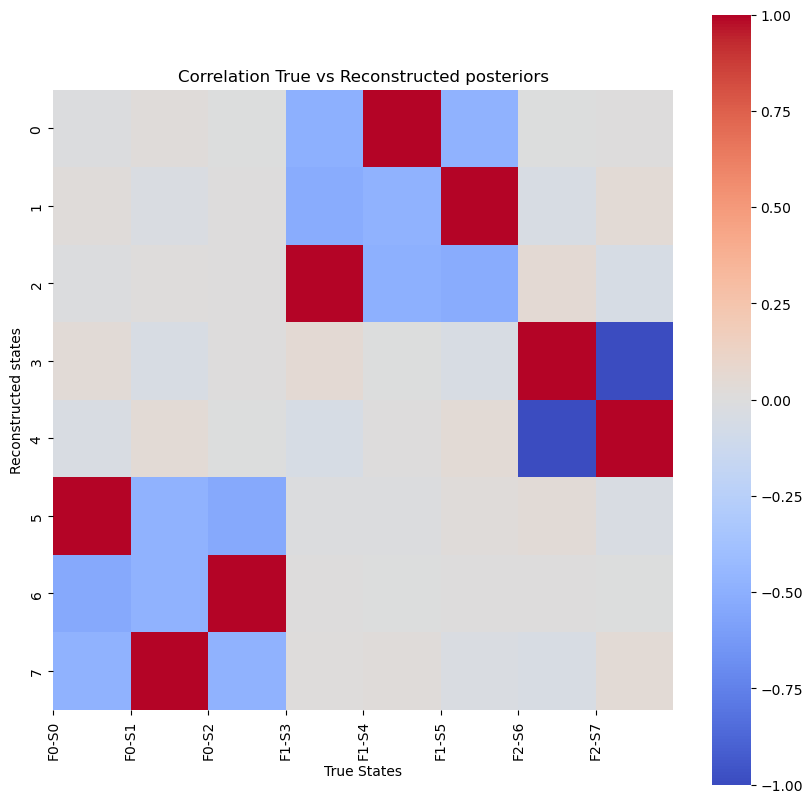

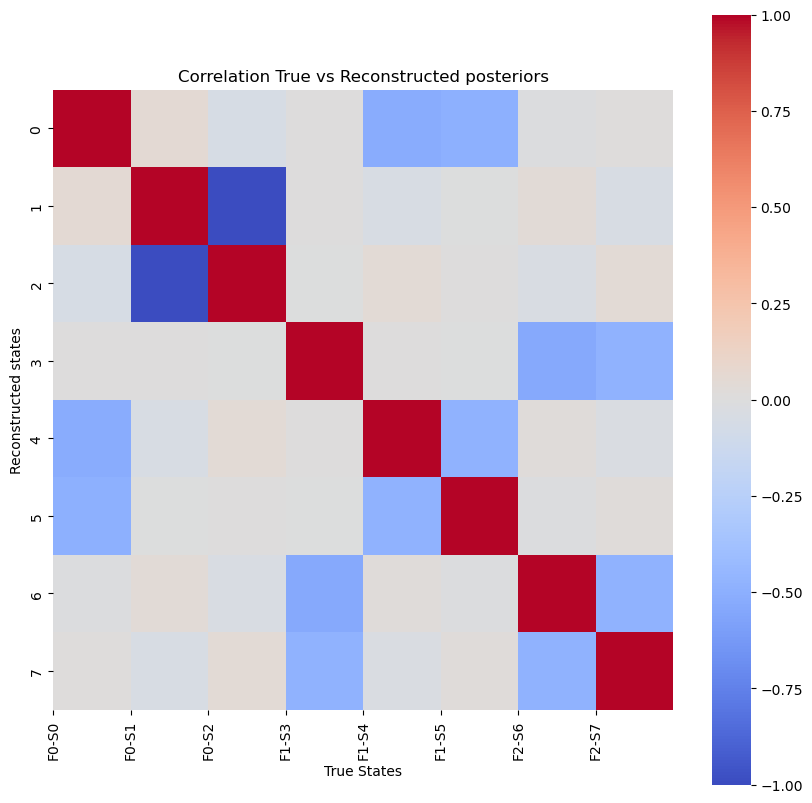

In [17]:


compare_reconstructed_true(means_rec_HMM,posteriors_rec_HMM,data)

Compare transition matrices and posteriors

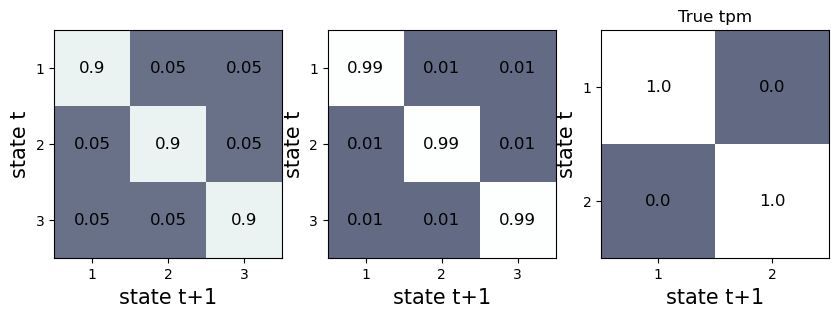

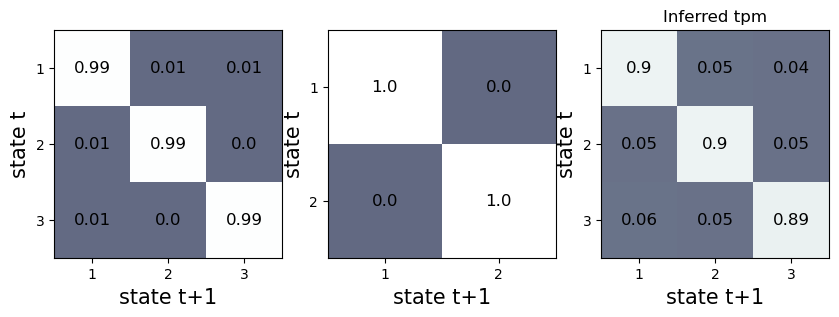

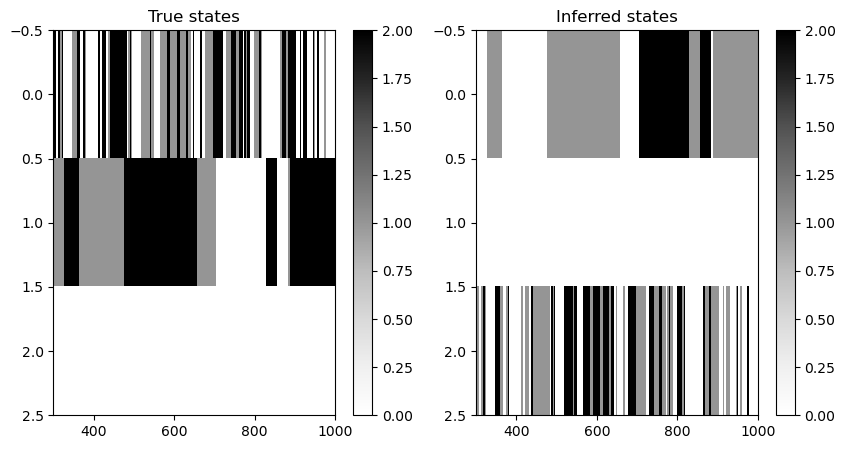

In [22]:

# Convert list of lists to a NumPy array for efficient processing
# factor_posteriors = [np.array(posteriors_rec[factor_idx]) for factor_idx in range(num_factors)]
# factor_posteriors=np.hstack(posteriors_rec)
# Compute the most likely states for each factor in a vectorized manner
most_likely_states = np.array([factor.argmax(axis=1) for factor in posteriors_rec_HMM]).T

plt.figure(figsize=(10, 15))
for i in range(num_factors):
    ax = plt.subplot(1, num_factors, i+1)
    plot_trans_matrix(data['params']['transition_matrices'][i])
ax.set_title("True tpm")
plt.savefig('fig_modelsel/GroundTruth_compare_transitions_true.pdf')
plt.savefig('fig_modelsel/GroundTruth_compare_transitions_true.png')

plt.figure(figsize=(10, 15))
for i in range(num_factors):
    ax = plt.subplot(1, num_factors, i+1)
    plot_trans_matrix(transitions_rec_HMM[i])
ax.set_title("Inferred tpm")
plt.savefig('fig_modelsel/GroundTruth_compare_transitions_fit.pdf')
plt.savefig('fig_modelsel/GroundTruth_compare_transitions_fit.png')



fig, axs = plt.subplots(1, 2, sharex=True, figsize=(10, 5)) 
axs[0].imshow(data['fHMM_data']['true_states'].T, aspect="auto", interpolation="none", cmap="Greys")
axs[1].imshow(most_likely_states.T, aspect="auto", interpolation="none", cmap="Greys")

# add colorbars
axs[0].set_title("True states")
axs[1].set_title("Inferred states")
plt.colorbar(axs[0].imshow(data['fHMM_data']['true_states'].T, aspect="auto", interpolation="none", cmap="Greys"), ax=axs[0])
plt.colorbar(axs[1].imshow(most_likely_states.T, aspect="auto", interpolation="none", cmap="Greys"), ax=axs[1])
plt.xlim(300, 1000)
plt.savefig('fig_modelsel/GroundTruth_compare_posteriors.pdf')


Compile and save results


In [ ]:
emissions_ccf=emissions_data


means_rec_GMM=means_rec
posteriors_rec_GMM=posteriors_rec
transitions_rec_GMM=transitions_rec
init_rec_GMM=init_rec
n_states_best_line_method_GMM=[]; n_states_best_eyeball_GMM=[]
n_states_best_dict_GMM = {'line method': n_states_best_GMM,
                          'new line method': n_states_best_line_method_GMM,
                          'eyeball method' : n_states_best_eyeball_GMM}

instantiation_rec_dict = {'means_gmm': means_rec_GMM,
                          'posteriors_gmm': posteriors_rec_GMM,
                          'transitions_gmm': transitions_rec_GMM,
                          'initial_states_gmm': init_rec_GMM,
                          'n_states_best_dict_gmm': n_states_best_dict_GMM,
                          'n_states_results_gmm': results_GMM,
                        #   'means_hmm': means_rec_HMM,
                        #   'posteriors_hmm': posteriors_rec_HMM,
                        #   'transitions_hmm': transitions_rec_HMM,
                        #   'initial_states_hmm': init_rec_HMM,
                        #   'n_states_best_dict_hmm': n_states_best_dict_HMM,
                        #   'n_states_results_hmm': results_HMM,
                          'variances': sigmas,
                          'emissions_ccf': emissions_ccf, # only needed for CCF aggregated data
                          # 'emissions_pca': emissions_data, # only needed for the PCA case
                          # 'emissions': activity, # only needed for the raw data case
                        #   'df_behavior': df_behavior,
                          # 'areas_list': areas_list,
                          # 'areas_pca': areas_list_pca,
                          # 'activity': activity,
                          # 'activity_pca': activity_pca,
                        #   'units': df_units,
                          # 'params': params, # Only needed for arameter recovery
                          # 'true_states': true_states, # Only needed for arameter recovery
                        #   'mapping_df' : mapping_df # Only needed for CCF aggregated data
                          # 'expec_emissions': expec_emissions, # Only needed for arameter recovery
                          # 'pca_dict' : pca_dict # Only needed for the PCA case
                         }

flat_one_hot_states=[]; state_factors=[]
for f in range(num_factors):
    states_f = np.eye(num_states[f])[true_states[:, f]]  # One-hot encode each factor separately
    flat_one_hot_states.append(states_f)



instantiation_truth_dict = {'params': data['params'],
                          'posteriors': flat_one_hot_states,
                          # 'n_states_results_gmm': results_GMM,
                        #   'means_hmm': means_rec_HMM,
                        #   'posteriors_hmm': posteriors_rec_HMM,
                        #   'transitions_hmm': transitions_rec_HMM,
                        #   'initial_states_hmm': init_rec_HMM,
                        #   'n_states_best_dict_hmm': n_states_best_dict_HMM,
                        #   'n_states_results_hmm': results_HMM,
                          # 'variances': data['params']['variances'],
                          'emissions_ccf': emissions_ccf, # only needed for CCF aggregated data
                          # 'emissions_pca': emissions_data, # only needed for the PCA case
                          # 'emissions': activity, # only needed for the raw data case
                        #   'df_behavior': df_behavior,
                          # 'areas_list': areas_list,
                          # 'areas_pca': areas_list_pca,
                          # 'activity': activity,
                          # 'activity_pca': activity_pca,
                        #   'units': df_units,
                          # 'params': params, # Only needed for arameter recovery
                          # 'true_states': true_states, # Only needed for arameter recovery
                        #   'mapping_df' : mapping_df # Only needed for CCF aggregated data
                          'expec_emissions': expec_emissions, # Only needed for arameter recovery
                          # 'pca_dict' : pca_dict # Only needed for the PCA case
                         }

filename = 'test_states333'
instantiation_recs_dict_name = 'data/parameter_recovery_instantiation_recs_' + filename + '.npy'
instantiation_truth_dict_name = 'data/parameter_recovery_instantiation_truth_' + filename + '.npy'

np.save(instantiation_recs_dict_name, instantiation_rec_dict)
np.save(instantiation_truth_dict_name, instantiation_truth_dict)